In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools
from scipy.special import logsumexp

#### General procedure:

1. Initialize all the parameters, say, $\mu, a, z$;
2. For all the data pairs $(C_k, T_k)$, where $C_k$ is the crossed boundary and $T_k$ is the first passage time, compute the probability $\mathbb{P}(\tilde{X}_{\lfloor T_k/\Delta t\rfloor}=C_k)$;
3. For the approximate process, 
4. 
5.

In [2]:
def MCsample(P, init_dist, k): 
    """
    sample a 'k'-step Markov chain 
    with initial distribution 'init_dist'
    and transition probabilities 'P'
    """
    s = len(init_dist) # num of states
    X = np.zeros(k)
    X[0] = np.random.choice(s, p=init_dist)
    for i in range(1, k):
        X[i] = np.random.choice(s, p=P[int(X[i-1]), :])
    return X


In [3]:
def logdotexp(A, B):
    """
    numerically stable ways to compute
    np.log(np.dot(np.exp(A), np.exp(B)))
    A, B are 2d arrays satisfying A.shape[1] = B.shape[0]
    """
    assert len(A.shape) == 2
    assert len(B.shape) == 2
    assert A.shape[1] == B.shape[0]
    A_ = np.stack([A] * B.shape[1]).transpose(1, 0, 2)
    B_ = np.stack([B] * A.shape[0]).transpose(0, 2, 1)
    return logsumexp(A_ + B_, axis=2)


advection-diffusion equation:
$$
\begin{aligned}
u_t+cu_x&=\nu u_xx\\
u(x,0)&=f(x)\\
u(0,t)&=u(a,t)=0\\
\end{aligned}
$$
Crank-Nicolson:
$$
\begin{aligned}
\tfrac{u_j^{n+1}-u_j^n}{\Delta t}+\tfrac{c}{2} \left(\tfrac{u_{j+1}^{n+1}-u_{j-1}^{n+1}}{2 \Delta x}+\tfrac{u_{j+1}^n-u_{j-1}^n}{2 \Delta x}\right)&=\tfrac{\nu}{2} \tfrac{u_{j+1}^n-2 u_j^n+u_{j-1}^n}{(\Delta x)^2}+\tfrac{\nu}{2} \tfrac{u_{j+1}^{n+1}-2 u_j^{n+1}+u_{j-1}^{n+1}}{(\Delta x)^2}\\
u^{0}_{j}&=f(x_j)\\
u^j_{0}&=u^j_{N_x}=0
\end{aligned}\\
$$
which can be simplified as
$$
\left(-\tfrac{\lambda}{4}-\tfrac{\mu}{2}\right) u_{j-1}^{n+1}+(1+\mu) u_j^{n+1}+\left(\tfrac{\lambda}{4}-\tfrac{\mu}{2}\right) u_{j+1}^{n+1}=\left(\tfrac{\lambda}{4}+\tfrac{\mu}{2}\right) u_{j-1}^n+(1-\mu) u_j^n+\left(-\tfrac{\lambda}{4}+\tfrac{\mu}{2}\right) u_{j+1}^n
$$

In [4]:
def solve_ADVD(c, D, x_range, t_range, f, Nx, Nt):
    """Solve
    u_t + c * u_x = D * u_xx
    with initial condition f(x) and homogeneous Dirichlet boundary
    """
    # Crank-Nicolson
    xmin, xmax = x_range
    tmin, tmax = t_range
    x_grid = np.linspace(xmin, xmax, Nx + 1)
    t_grid = np.linspace(tmin, tmax, Nt + 1)
    dx = x_grid[1] - x_grid[0]
    dt = t_grid[1] - t_grid[0]
    lam = c * dt / dx
    mu = D * dt / dx ** 2
    u_grid = np.zeros([Nx + 1, Nt + 1])
    u_grid[:, 0] = f(x_grid)

    I = np.eye(Nx - 1)
    I1 = np.diag(np.ones(Nx-2), 1)
    I2 = np.diag(np.ones(Nx-2), -1)
    A = (1 + mu) * I - (lam / 4 + mu / 2) * I1 + (lam / 4 - mu / 2) * I2
    B = 2 * I - A
    C = np.linalg.solve(A, B)

    for t_step in range(Nt):
        u_grid[1:-1, t_step + 1] = C @ u_grid[1:-1, t_step]

    return x_grid, t_grid, u_grid

In one spatial dimension $x$, for an Itô process driven by the standard Wiener process $W_t$ and described by the stochastic differential equation (SDE)
$$
\begin{aligned}
\mathrm{d} X(t)&=\mu\left(X(t), t\right) \mathrm{d} t+\sigma\left(X(t), t\right) \mathrm{d} W(t)\\
X(t)&=X(0)+\int_0^t \mu(X(s), s) \mathrm{d} s+\int_0^t \sigma(X(s), s) \mathrm{d}W(s)
\end{aligned}
$$
with drift $\mu(X(t), t)$ and diffusion coefficient $\sigma^2(X(t), t)/2$, the Kolmogorov forward equation (Fokker-Planck equation) for the transition probability density $f(x,t|y,s)$ (defined as $f(x,t|y,s)\mathrm{d}x=\mathbb{P}(X(t)\in[x,x+\mathrm{d}x)|X(s)=y)$) of the random variable $X(t)$ is
$$
\tfrac{\partial}{\partial t} f(x, t|y, s)=-\tfrac{\partial}{\partial x}[\mu(x, t) f(x, t|y,s)]+\tfrac{1}{2}\tfrac{\partial^2}{\partial x^2}[\sigma^2(x, t) f(x, t|y,s)],\text{ for } t\ge s
$$
the Kolmogorov backward equation is
$$
\tfrac{\partial}{\partial s} f(x, t|y,s)=-\mu(x, t) \tfrac{\partial}{\partial y} f(x, t|y,s)-\tfrac{1}{2} \sigma^2(x, t) \tfrac{\partial^2}{\partial y^2} f(x, t|y,s),\text{ for } s< t
$$


### Drift-diffusion model
Consider the following stochastic process on the interval $[0, a]$ with absorbing boundaries:
$$
\begin{aligned}
\mathrm{d} X(t)&=\mu(t)\mathrm{d} t +\sigma\mathrm{d} W(t)\\
X(t)&=z+\int_{0}^{t}\mu(r)\mathrm{d} r +\sigma W(t)
\end{aligned}
$$
with starting point $z\in(0, a)$.

The Fokker-Planck equation corresponds to drift-diffusion model is
$$
\begin{aligned}
\tfrac{\partial}{\partial t} f(x, t|z,0)&=-\mu\tfrac{\partial}{\partial x}f(x, t|z,0)+\tfrac{1}{2}\sigma^2\tfrac{\partial^2}{\partial x^2}f(x, t|z,0)\\
f(x, 0|z,0)&=\delta(x-z)\\
f(0,t|z,0)&=f(a,t|z,0)=0
\end{aligned}
$$

In [5]:
class DDModel(object):
    def __init__(self, mu=1, sigma=1) -> None:
        self.mu = mu
        self.sigma = sigma

    def strong_Euler(self, init_cond, T, Nt=1000):
        t0, u0 = init_cond
        dt = float(T - t0) / Nt
        t_grid = np.arange(t0, T + dt, dt)
        u_grid = np.zeros(Nt + 1)
        u_grid[0] = u0
        for i in range(1, Nt + 1):
            t = t0 + (i - 1) * dt
            u = u_grid[i - 1]
            dW = np.random.normal(loc=0.0, scale=np.sqrt(dt))
            u_grid[i] = u + self.mu * dt + self.sigma * dW
        return t_grid, u_grid

    def weak_Euler(self, init_cond, T, Nt=1000):
        t0, u0 = init_cond
        dt = float(T - t0) / Nt
        t_grid = np.arange(t0, T + dt, dt)
        u_grid = np.zeros(Nt + 1)
        u_grid[0] = u0
        for i in range(1, Nt + 1):
            t = t0 + (i - 1) * dt
            u = u_grid[i - 1]
            dW_ = (2 * (np.random.uniform() < 0.5) - 1) * np.sqrt(dt)
            u_grid[i] = u + self.mu * dt + self.sigma * dW_
        return t_grid, u_grid

    def generate_data(self, a, z, dt=0.001, num=1, return_traj=False):
        """
        generate 'num' data pairs of the form (C, T)
        where C is the crossed boundary (0 or a)
              T is the first passage time
        """
        data = np.zeros((num, 2))
        trajs = []
        for i in range(num):
            if return_traj:
                t_grid = [0]
                u_grid = [z]
            u = z
            steps = 0
            while u > 0 and u < a:
                dW = np.random.normal(loc=0.0, scale=np.sqrt(dt))
                u += self.mu * dt + self.sigma * dW
                steps += 1
                if return_traj:
                    t_grid.append(steps * dt)
                    u_grid.append(u)
            data[i] = a if u > a / 2 else 0, steps * dt
            if return_traj:
                trajs.append(np.array([t_grid, u_grid]))
        return data, trajs
    
    def fokker_planck(self, a, T, z, Nx, Nt):
        f = lambda x: Nx/a * 1 * (x==z)
        x_grid, t_grid, u_grid = solve_ADVD(self.mu, self.sigma**2/2, [0, a], [0, T], f, Nx, Nt)
        return x_grid, t_grid, u_grid


In [6]:
ddm = DDModel(mu=0.2, sigma=1)
data, trajs = ddm.generate_data(a=4, z=2, num=100, return_traj=True)


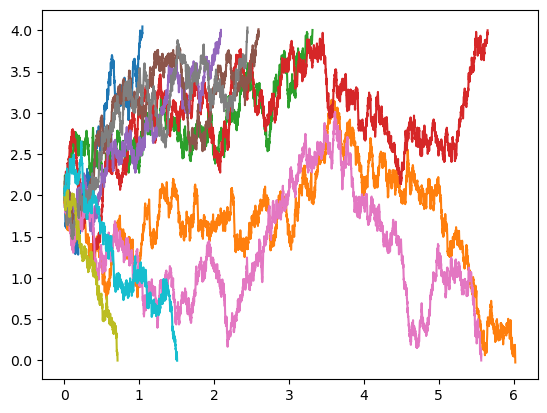

In [7]:
for traj in trajs[:10]:
    plt.plot(traj[0], traj[1])

To approximate this process,  we discretize the time and space with step size $\Delta t$ and $\Delta x$ respectively, 
and consider a discrete-time discrete-space Markov chain $\tilde{X}$ on the grid. We want the temporal interpolation of $\tilde{X}_j$ converges in distribution to $X$ as $\Delta t, \Delta x\rightarrow 0$.

Let $Z_0, Z_1, \cdots $ be a sequence of independent random variables with
$$
Z_{j}=\left\{
\begin{array}{ll}
      \Delta x & \text{w.p. } p^{+}_j \\
      0 & \text{w.p. } 1-p^{+}_j-p^{-}_j \\
      -\Delta x & \text{w.p. } p^{-}_j \\
\end{array} 
\right.  
$$
and $Y_n=\sum_{j=1}^n Z_j$ be the random walk of $Z_j$. Let $\Omega=\{0, 1, 2, \cdots, N_x, \beta\}$ be the state space of $\tilde{X}_j$, where $\beta$ is the absorbing state. When $0\le Y_j\le a$, we take $\tilde{X}_j=Y_j/\Delta x$; once $Y_j$ hits the boundary $0$ or $a$, we move the next step $\tilde{X}_j$ to the absorbing state $\beta$. Then the transition probability of $\tilde{X}_j$'s would be
$$
\mathcal{p}_{s_1s_2}(t_j)=\mathbb{P}(\tilde{X}_{j+1}=s_2\Delta x|\tilde{X}_{j}=s_1\Delta x)=
\left\{
\begin{array}{ll}
\mathbb{P}(Y_{j+1}=s_2\Delta x|Y_{j}=s_1\Delta x)=
\left\{
\begin{array}{ll}
      p^{+}_j & \text{if  } s_2-s_1=1 \\
      1-p^{+}_j-p^{-}_j & \text{if  } s_2-s_1=0 \\
      p^{-}_j & \text{if  } s_2-s_1=-1 \\
\end{array} 
\right. & \text{if  } s_1,s_2\in\Omega\backslash\{0,N_x,\beta\} \\
      1 & \text{if  } s_1\in\{0,N_x,\beta\}, s_2=\beta\\
      0 & \text{otherwise}  \\
\end{array} 
\right. 
$$

We try to match the first and second moment of $X((j+1)\Delta t)-X(j\Delta t)$ and $Z_j$, i.e. we let
$$
\begin{aligned}
(p_j^{+}-p_j^{-})\Delta x&=\textstyle \int_{j\Delta t}^{(j+1)\Delta t}\mu(r)\mathrm{d}r\\
(p_j^{+}+p_j^{-})(\Delta x)^2&=\left(\textstyle\int_{j\Delta t}^{(j+1)\Delta t}\mu(r)\mathrm{d}r\right)^2+\sigma^2\Delta t
\end{aligned}
$$
use a first order approximation for the integral, and let $\mu_j=\mu(j\Delta t)$, then 
$$
\begin{aligned}
(p_j^{+}-p_j^{-})\Delta x&=\mu_j\Delta t\\
(p_j^{+}+p_j^{-})(\Delta x)^2&=\mu_j^2(\Delta t)^2+\sigma^2\Delta t
\end{aligned}
$$
from which we can solve for $p_j^+$ and $p_j^-$ explicitly.
Note that we need to take suitable values of $\Delta t$ and $\Delta x$ to make $p_j^+$ and $p_j^-$ meaningful.

In [8]:
class approx_hmc(object):
    """
    Markov chain approximation (homogeneous case)
    """

    def __init__(self, mu, sigma, a, z, dt, Nx, verbose=True) -> None:
        self.mu = mu  # drift coeff (constant)
        self.sigma = sigma  # diffusion coeff (constant)
        self.a = a  # upper boundary
        self.z = z  # starting point
        self.Nx = Nx  # num of space steps

        self.dt = dt
        dx = a / Nx
        self.dx = dx

        self.idx_z = int(round(z / dx))  # index of starting point
        self.init_dist = np.zeros(self.Nx + 2)
        self.init_dist[self.idx_z] = 1

        # transition probability matrix
        # 0, 1, ..., Nx are transient states
        # Nx+1 is the absorbing state
        m1 = mu * dt
        m2 = (mu * dt) ** 2 + sigma ** 2 * dt
        self.p1 = (m2 / dx ** 2 + m1 / dx) / 2
        self.p2 = (m2 / dx ** 2 - m1 / dx) / 2
        assert self.p1 + self.p2 < 1, 'p+=%.5f, p0=%.5f, p-=%.5f' %(self.p1, 1-self.p1-self.p2, self.p2)
        self.P = np.zeros((self.Nx + 2, self.Nx + 2))
        self.P[0, self.Nx + 1] = 1
        self.P[self.Nx, self.Nx + 1] = 1
        self.P[self.Nx + 1, self.Nx + 1] = 1
        for i in range(1, self.Nx):
            self.P[i, i - 1] = self.p2
            self.P[i, i] = 1 - self.p1 - self.p2
            self.P[i, i + 1] = self.p1
        
        if verbose:
            self.summary() 

    def ExitDist(self, T):
        """
        compute the distribution of X[T]
        where T is the first passage time
        """
        dist_Xt = self.init_dist
        idx_T = int(round(T / self.dt))

        for t_step in range(idx_T):
            dist_Xt = dist_Xt @ self.P
        return dist_Xt

    def ExitProb_dp(self, T, s):
        """
        compute the probability of P(X[T]=s)
        where t is the first passage time
        by DYNAMIC PROGRAMMING
        s: value in [0, a]
        """
        idx_T = int(round(T / self.dt))
        idx_s = int(round(s / self.dx))
        table = np.zeros((idx_T - 1, self.Nx + 2))
        table[idx_T - 2] = self.P @ self.P[:, idx_s]
        for t_step in range(idx_T - 3, -1, -1):
            table[t_step] = self.P @ table[t_step + 1]
        return table[0] @ self.init_dist
    
    def ExitProb_logdp(self, T, s):
        """
        compute the probability of P(X[T]=s) in log scale
        where t is the first passage time
        by DYNAMIC PROGRAMMING
        s: value in [0, a]
        """
        idx_T = int(round(T / self.dt))
        idx_s = int(round(s / self.dx))
        logP = np.log(self.P)
        logtable = np.zeros((idx_T - 1, self.Nx + 2))
        tmp = logdotexp(logP, logP[:, idx_s].reshape(-1,1))
        logtable[idx_T - 2,:] = tmp.reshape(-1)
        for t_step in range(idx_T - 3, -1, -1):
            tmp = logdotexp(logP, logtable[t_step + 1].reshape(-1,1))
            logtable[t_step] = tmp.reshape(-1)
        logprob = logdotexp(logtable[0].reshape(1,-1), np.log(self.init_dist).reshape(-1,1))
        return np.squeeze(np.exp(logprob))[()]

    def ExitProb_test(self, T, s):
        """
        compute the probability of P(X[T]=s)
        where t is the first passage time
        by BRUTAL FORCE (only used for testing!)
        s: value in [0, a]
        """
        idx_T = int(round(T / self.dt))
        idx_s = int(round(s / self.dx))
        ranges = [range(self.Nx + 2)] * (idx_T - 1)
        prob = 0
        for xs in itertools.product(*ranges):
            prob_traj = self.P[self.idx_z, xs[0]] * self.P[xs[-1], idx_s]
            for l in range(len(xs) - 1):
                prob_traj *= self.P[xs[l], xs[l + 1]]
            prob += prob_traj
        return prob

    def summary(self):
        print("mu: %.3f" % self.mu)
        print("sigma: %.3f" % self.sigma)
        print("a: %.3f" % self.a)
        print("z: %.3f" % self.z)

        print("dt: %.5f" % self.dt)
        print("dx: %.5f" % self.dx)
        print("Nx: %d" % self.Nx)
        print("shape of P: " + str(self.P.shape))
        print("p+, p0, p-: %.5f, %.5f, %.5f" % (self.p1, 1 - self.p1 - self.p2, self.p2))


Let $\tau=\inf\{j\ge0:\tilde{X}_j=0\text{ or }a\}$ be the first passage time of $\tilde{X}_j$ through the boundary.
We want to compute 
$\mathbb{P}(\tilde{X}_\tau=0)$ and $\mathbb{P}(\tilde{X}_\tau=a)$.

$$
\begin{aligned}
\mathbb{P}(\tilde{X}_\tau=0)
&=\sum_{x_0, x_1,\cdots, x_{\tau-1}} \mathbb{P}(\tilde{X}_\tau=0|\tilde{X}_{\tau-1}=x_{\tau-1})\mathbb{P}(\tilde{X}_{\tau-1}=x_{\tau-1}|\tilde{X}_{\tau-2}=x_{\tau-2})\cdots\mathbb{P}(\tilde{X}_1=x_1|\tilde{X}_{0}=x_0)\mathbb{P}(\tilde{X}_{0}=x_0)\\
&=\sum_{x_0, x_1,\cdots, x_{\tau-2}}\underbrace{\sum_{x_{\tau-1}} \mathbb{P}(\tilde{X}_\tau=0|\tilde{X}_{\tau-1}=x_{\tau-1})\mathbb{P}(\tilde{X}_{\tau-1}=x_{\tau-1}|\tilde{X}_{\tau-2}=x_{\tau-2})}_{f_{\tau-2}(x_{\tau-2})}\cdots\mathbb{P}(\tilde{X}_1=x_1|\tilde{X}_{0}=x_0)\mathbb{P}(\tilde{X}_{0}=x_0)\\
&=\sum_{x_0, x_1,\cdots, x_{\tau-3}}\underbrace{\sum_{x_{\tau-2}}f_{\tau-2}(x_{\tau-2})\mathbb{P}(\tilde{X}_{\tau-2}=x_{\tau-2}|\tilde{X}_{\tau-3}=x_{\tau-3})}_{f_{\tau-3}(x_{\tau-3})}\cdots\mathbb{P}(\tilde{X}_1=x_1|\tilde{X}_{0}=x_0)\mathbb{P}(\tilde{X}_{0}=x_0)\\
&=\cdots\\
&=\sum_{x_0}\underbrace{\sum_{x_{1}}f_{1}(x_{1})\mathbb{P}(\tilde{X}_{1}=x_{1}|\tilde{X}_{0}=x_{0})}_{f_{0}(x_{0})}\mathbb{P}(\tilde{X}_{0}=x_0)\\

\end{aligned}
$$

$$
\begin{aligned}
f_{\tau-2}(x_{\tau-2})&=\sum_{x_{\tau-1}} \mathbb{P}(\tilde{X}_\tau=0|\tilde{X}_{\tau-1}=x_{\tau-1})\mathbb{P}(\tilde{X}_{\tau-1}=x_{\tau-1}|\tilde{X}_{\tau-2}=x_{\tau-2})\\
&=\sum_{x_{\tau-1}} p_{x_{\tau-1},0}(t_{\tau-1})p_{x_{\tau-2},x_{\tau-1}}(t_{\tau-2})\\
&=\text{row $x_{\tau-2}$ of $P(t_{\tau-2})$} \cdot \text{column 0 of $P(t_{\tau-1})$}\\
f_{\tau-3}(x_{\tau-3})&=\sum_{x_{\tau-2}} f_{\tau-2}(x_{\tau-2})p_{x_{\tau-3},x_{\tau-2}}(t_{\tau-3})\\
&=\text{row $x_{\tau-3}$ of $P(t_{\tau-3})$} \cdot f_{\tau-2}
\end{aligned}$$

#### An example:
$\mu=0.2, \sigma=1, a=4, z=2$. Set $\Delta t=0.1, \Delta x=0.8$, the state space $\Omega=\{0, 1,2,3,4,5,\beta\}$. The process exits boundary $a=0$ at time $1\ \mathrm{s}$.

In [13]:
mc1 = approx_hmc(mu=0.2, sigma=1, a=4, z=2, dt=0.001, Nx=100)

mu: 0.200
sigma: 1.000
a: 4.000
z: 2.000
dt: 0.00100
dx: 0.04000
Nx: 100
shape of P: (102, 102)
p+, p0, p-: 0.31501, 0.37498, 0.31001


In [14]:
T = 1
mc1.ExitDist(T)

array([7.09734097e-05, 2.29046908e-04, 4.62140012e-04, 6.99696902e-04,
       9.42136766e-04, 1.18987490e-03, 1.44331708e-03, 1.70285383e-03,
       1.96885467e-03, 2.24166230e-03, 2.52158688e-03, 2.80890035e-03,
       3.10383096e-03, 3.40655787e-03, 3.71720609e-03, 4.03584171e-03,
       4.36246737e-03, 4.69701827e-03, 5.03935845e-03, 5.38927775e-03,
       5.74648915e-03, 6.11062673e-03, 6.48124433e-03, 6.85781471e-03,
       7.23972953e-03, 7.62629996e-03, 8.01675804e-03, 8.41025877e-03,
       8.80588294e-03, 9.20264072e-03, 9.59947597e-03, 9.99527127e-03,
       1.03888536e-02, 1.07790008e-02, 1.11644485e-02, 1.15438977e-02,
       1.19160227e-02, 1.22794799e-02, 1.26329163e-02, 1.29749793e-02,
       1.33043252e-02, 1.36196295e-02, 1.39195963e-02, 1.42029673e-02,
       1.44685319e-02, 1.47151358e-02, 1.49416898e-02, 1.51471784e-02,
       1.53306674e-02, 1.54913111e-02, 1.56283589e-02, 1.57411609e-02,
       1.58291730e-02, 1.58919609e-02, 1.59292029e-02, 1.59406925e-02,
      

In [15]:
[mc1.ExitProb_dp(T, i*mc1.dx) for i in range(mc1.Nx+1)]

[7.097340971759213e-05,
 0.00022904690756461558,
 0.00046214001153920133,
 0.0006996969015345604,
 0.0009421367657166566,
 0.001189874899575172,
 0.001443317077940867,
 0.0017028538313321525,
 0.0019688546697718134,
 0.002241662299129448,
 0.0025215868767813877,
 0.0028089003549015452,
 0.00310383096096401,
 0.003406557866008955,
 0.003717206091853694,
 0.004035841708675962,
 0.004362467374212339,
 0.004697018265159373,
 0.005039358450198579,
 0.005389277752354676,
 0.005746489146109565,
 0.0061106267318107215,
 0.0064812443264173555,
 0.006857814705516236,
 0.00723972952681631,
 0.007626299960013857,
 0.00801675804203389,
 0.008410258770240221,
 0.008805882939314644,
 0.009202640720199606,
 0.009599475971850766,
 0.009995271268641298,
 0.010388853618191668,
 0.010779000836268485,
 0.011164448537313104,
 0.01154389769123793,
 0.011916022689482232,
 0.012279479856068226,
 0.012632916332658145,
 0.012974979260497614,
 0.013304325176748557,
 0.01361962953816545,
 0.013919596281443462,
 0.

In [16]:
[mc1.ExitProb_logdp(T, i*mc1.dx) for i in range(mc1.Nx+1)]

/users/sliu167/anaconda/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in log
/users/sliu167/anaconda/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log


[7.097340971759077e-05,
 0.0002290469075646202,
 0.00046214001153923207,
 0.0006996969015346306,
 0.0009421367657167708,
 0.0011898748995753362,
 0.001443317077941074,
 0.0017028538313324,
 0.001968854669772102,
 0.0022416622991297754,
 0.0025215868767817624,
 0.0028089003549019633,
 0.0031038309609644735,
 0.0034065578660094583,
 0.0037172060918542332,
 0.00403584170867656,
 0.004362467374212962,
 0.004697018265160051,
 0.005039358450199304,
 0.005389277752355456,
 0.00574648914611036,
 0.006110626731811585,
 0.006481244326418258,
 0.006857814705517171,
 0.007239729526817282,
 0.007626299960014897,
 0.008016758042034966,
 0.008410258770241328,
 0.00880588293931581,
 0.009202640720200824,
 0.009599475971852026,
 0.009995271268642582,
 0.01038885361819302,
 0.010779000836269858,
 0.011164448537314547,
 0.011543897691239384,
 0.011916022689483717,
 0.012279479856069758,
 0.012632916332659724,
 0.012974979260499186,
 0.013304325176750188,
 0.013619629538167094,
 0.013919596281445122,
 0.0

In [19]:
[mc1.ExitProb_test(T, i*mc1.dx) for i in range(mc1.Nx+1)]

[0.011615128512935207,
 0.1719825062094189,
 0.33317925015201594,
 0.2580708149203154,
 0.10649939955506589,
 0.008936387769429505]

The first passage

In [17]:
def LogLikelihood(chain, data):
    """
    compute the likelihood: product of P(X(Tk)=Ck)
    """
    logprob = 0 
    for Ck, Tk in data:
        logprob += np.log(chain.ExitProb_logdp(Tk, Ck))
        if np.isinf(logprob):
            raise ValueError('Infty detected, computation is stopped.')
    return logprob

In [18]:
LogLikelihood(mc1, data)

/users/sliu167/anaconda/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in log
/users/sliu167/anaconda/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log


-977.9802309749736

In [22]:
mu_list = np.arange(-1, 1, 0.005)
probs_list = []
for mu in mu_list:
    chain = approx_hmc(mu=mu, sigma=1, a=4, z=2, dt=0.001, Nx=100, verbose=False)
    probs_list.append(LogLikelihood(chain, data))

/users/sliu167/anaconda/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in log
/users/sliu167/anaconda/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log


In [18]:
print(probs_list)

[-842.625348753441, -837.6587949742149, -832.7260207109962, -827.8272367825657, -822.9626521393452, -818.1324738548898, -813.33690711781, -808.5761552241154, -803.8504195699339, -799.1598996446588, -794.5047930244721, -789.8852953662571, -785.3016004018947, -780.7538999329271, -776.2423838255935, -771.7672400062246, -767.3286544569901, -762.9268112119832, -758.5618923536664, -754.2340780096216, -749.9435463496433, -745.690473583146, -741.4750339568712, -737.2973997529132, -733.1577412870206, -729.0562269071994, -724.9930229925903, -720.9682939526151, -716.9822022263926, -713.0349082824065, -709.1265706184214, -705.2573457616369, -701.4273882690883, -697.6368507282531, -693.8858837578905, -690.1746360090797, -686.503254166463, -682.8718829496862, -679.2806651150285, -675.7297414571923, -672.2192508112895, -668.7493300549689, -665.3201141107172, -661.9317359482958, -658.58432658732, -655.2780150999781, -652.0129286138681, -648.789192314962, -645.6069294506702, -642.4662613330181, -639.36

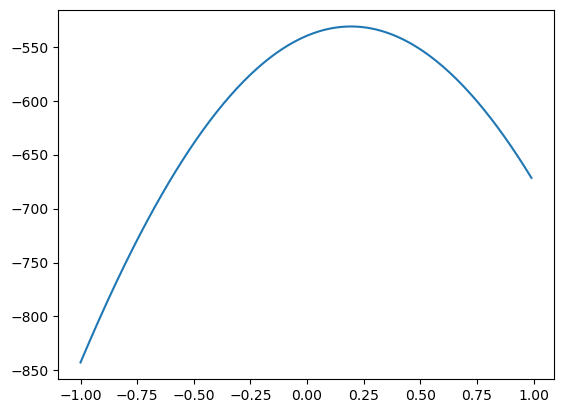

In [19]:
plt.plot(mu_list, probs_list)

In [20]:
mu_list[np.argmax(probs_list)]

0.19000000000000106